In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import open3d as o3d

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
c = np.load('./casper/calib.npy', allow_pickle=True).item()

In [3]:
c

{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]),
 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]),
 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
        [ 0.07619891,  0.99687725,  0.02072451],
        [-0.39852369,  0.01139647,  0.91708726]]),
 't': array([[-407.240143 ],
        [  -1.5053668],
        [  85.688652 ]])}

# Ex 13.2

In [4]:
img0 = cv2.imread('./casper/frame0/00.png')
size = (img0.shape[1], img0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'], c['d1'], size, c['R'], c['t'], flags=0)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

In [5]:
Img0List = []
for f in os.listdir('./casper/frame0/'):
    if f.endswith('png'):
        Img0List.append(os.path.join('./casper/frame0/', f))
Img0List = sorted(Img0List)

Img1List = []
for f in os.listdir('./casper/frame1/'):
    if f.endswith('png'):
        Img1List.append(os.path.join('./casper/frame1/', f))
Img1List = sorted(Img1List)

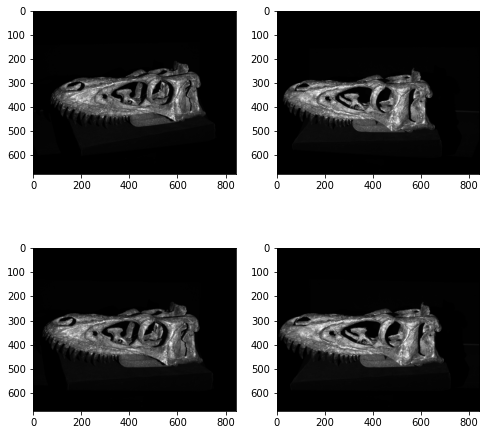

In [6]:
Images0 = []
Images1 = []
for i in range(len(Img0List)):
    img0 = cv2.imread(Img0List[i])
    img1 = cv2.imread(Img1List[i])
    gray0 = cv2.cvtColor(img0.copy(), cv2.COLOR_BGR2GRAY).astype('float32')
    gray1 = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2GRAY).astype('float32')
    
    img0_remap = cv2.remap(gray0.copy(), maps0[0], maps0[1], cv2.INTER_LINEAR)
    img1_remap = cv2.remap(gray1.copy(), maps1[0], maps1[1], cv2.INTER_LINEAR)
    Images0.append(img0_remap)
    Images1.append(img1_remap)
    
    if i==0:
        plt.figure(figsize=(8,8))
        plt.subplot(2,2,1)
        plt.imshow(gray0, cmap='gray')
        plt.subplot(2,2,2)
        plt.imshow(gray1, cmap='gray')
        plt.subplot(2,2,3)
        plt.imshow(img0_remap, cmap='gray')
        plt.subplot(2,2,4)
        plt.imshow(img1_remap, cmap='gray')
    
    

# Ex 13.3

In [7]:
def unwrap(Images, n=40):
    primary_images = Images[2:18]
    secondary_images = Images[18:]
    n = 40

    ## Find primarty spectrums
    fft_primary = np.fft.rfft(primary_images, axis=0)

    ## Get phase
    ### The Fourier component corresponding to the pattern is in the second component
    n_X_theta_primary = np.angle(fft_primary[1]) 
    theta_primary = np.mod(n_X_theta_primary.copy(), 2*np.pi)


    ## Find secondary spectrums
    fft_secondary = np.fft.rfft(secondary_images, axis=0)

    ## Get phase
    ### The Fourier component corresponding to the pattern is in the second component
    n_X_theta_secondary = np.angle(fft_secondary[1])
    theta_secondary = np.mod(n_X_theta_secondary.copy(), 2*np.pi)

    ## Get phase cue
    phase_cue = np.mod((theta_secondary - theta_primary), 2*np.pi)
    Pi_phase_cue = theta_secondary - theta_primary

    ## Get order
    order = ((n * Pi_phase_cue) - n_X_theta_primary)/(2*np.pi)
    order = np.round(order, 0)

    
    ## Get final theta 
    theta_estimated = np.mod((2*np.pi*order + n_X_theta_primary)/n, 2*np.pi)
    #theta_estimated = np.mod((2*np.pi*order)/n, 2*np.pi)
    print(theta_estimated.max())
    return theta_estimated

In [8]:
def unwrap(Images, n=40):
    primary_images = Images[2:18]
    secondary_images = Images[18:]
    n = 40

    ## Find primarty spectrums
    fft_primary = np.fft.rfft(primary_images, axis=0)

    ## Get phase
    ### The Fourier component corresponding to the pattern is in the second component
    n_X_theta_primary = np.angle(fft_primary[1]) 
    theta_primary = np.mod(n_X_theta_primary.copy(), 2*np.pi)


    ## Find secondary spectrums
    fft_secondary = np.fft.rfft(secondary_images, axis=0)

    ## Get phase
    ### The Fourier component corresponding to the pattern is in the second component
    n_X_theta_secondary = np.angle(fft_secondary[1])
    theta_secondary = np.mod(n_X_theta_secondary.copy(), 2*np.pi)

    ## Get phase cue
    phase_cue = np.mod((theta_secondary - theta_primary), 2*np.pi)

    ## Get order
    order = ((n * phase_cue) - theta_primary)/(2*np.pi)

    
    ## Get final theta 
    theta_estimated = np.mod((2*np.pi*order + theta_primary)/n, 2*np.pi)
    return theta_estimated

In [9]:
theta0 = unwrap(Images0) 
theta1 = unwrap(Images1)

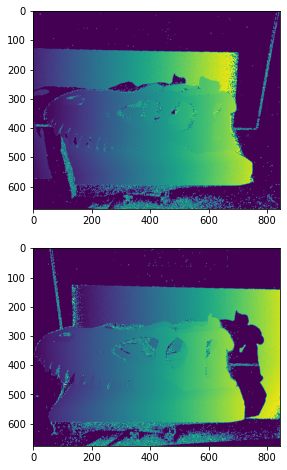

In [10]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.imshow(theta0)
plt.subplot(2,1,2)
plt.imshow(theta1)

# Ex 13.4

In [11]:
def theta_mask(theta, Images, thresh=15):
    img_substract = Images[0] - Images[1]
    ret, mask = cv2.threshold(img_substract.astype('uint8').copy(), thresh, 255, cv2.THRESH_BINARY)
    mask[np.where(mask==255)] = 1
    theta = theta * mask
    return theta, mask

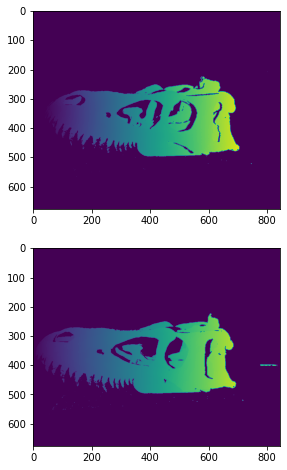

In [12]:
theta0, mask0 = theta_mask(theta0, Images0)
theta1, mask1 = theta_mask(theta1, Images1)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.imshow(theta0)
plt.subplot(2,1,2)
plt.imshow(theta1)

In [13]:
theta0[300, 201]

1.315354492801701

In [14]:
theta0[300, 202]

1.3188501558311376

# Ex 13.5

In [15]:
q0s = []
q1s = []

disparity = np.zeros_like(theta0).astype('float32')
rows, columns = theta0.shape
for i in range(rows):
    for j in range(columns):
        if theta0[i,j] != 0:
            error = []
            for k in range(columns):
                distance = np.abs(theta0[i, j] - theta1[i, k])
                error.append(distance)
            error = np.array(error)
            column_index_1 = error.argmin()
            disparity[i, j] = j - column_index_1
            q0s.append([j,i])
            q1s.append([column_index_1, i])


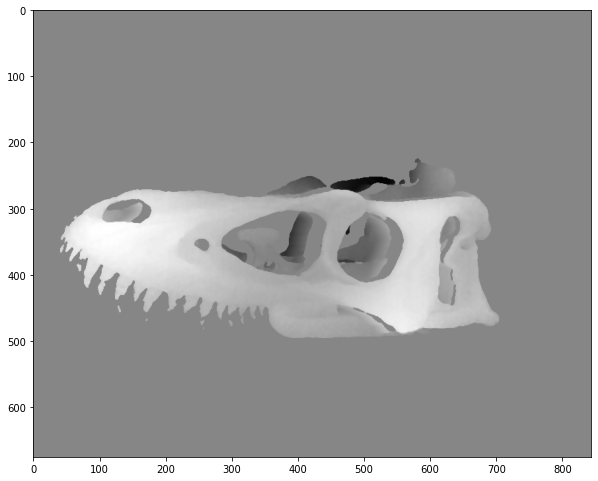

In [16]:
disparity = cv2.medianBlur(disparity.astype('float32'), 5)
plt.figure(figsize=(10, 10))
plt.imshow(disparity, cmap='gray')

# Ex 13.6

In [17]:
#q0s = np.array(q0s).astype('float32')
#q1s = np.array(q1s).astype('float32')
a = np.array(q0s)
b = np.array(q1s)
q0points = np.array([a[:, 0], a[:, 1]]).astype('float64')
q1points = np.array([b[:, 0], b[:, 1]]).astype('float64')

ThreeD_Points = cv2.triangulatePoints(P0, P1, q0points, q1points)
ThreeD_Points = ThreeD_Points[:-1]/ThreeD_Points[-1]

In [20]:
q0array = np.array(q0s).astype('float64')
q1array = np.array(q1s).astype('float64')

ThreeD_Points = cv2.triangulatePoints(P0, P1, q0array.T, q1array.T)
ThreeD_Points = ThreeD_Points[:-1]/ThreeD_Points[-1]
index = np.where(ThreeD_Points[2]<-2500)
ThreeD_Points[2, index] = 0

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(ThreeD_Points.T)

Colors = []
for i in range(len(q0s)):
    
    rand_color = [0.3/len(q0s)*i + 0.05, 0.7/len(q0s)*i + 0.07, 1/len(q0s) * i]
    #rand_color = [0.1, 0.2, 0.8/len(q0s)*i + 0.1]
    Colors.append(rand_color)

Colors = np.array(Colors).astype('float64')
pcd.colors = o3d.utility.Vector3dVector(Colors)

o3d.visualization.draw_geometries([pcd])

In [462]:
o3d.io.write_point_cloud('./week13.pcd', pcd)

True

In [458]:
pwd

'/Users/lijiahao/Desktop/Course/Computer_Vision/Week13'

In [475]:
ThreeD_Points[2].min()

-10240.744